In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
transaction = pyreadr.read_r("/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds")
df = transaction[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()

,id,type,timestamp,user,userAlias,onBehalfOf,onBehalfOfAlias,pool,reserve,amount,...,priceInUsd,borrowRateModeTo,borrowRateModeFrom,stableBorrowRate,variableBorrowRate,target,totalFee,version,deployment,DateTime
0,0xc70f4c3f447f6a88e9fbb87ac1394b589e469ee57dda...,borrow,1.606841e+09,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Kuhu Amphonephong,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Kuhu Amphonephong,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-01 11:46:58
1,0x1ee3db904548c16d2ed3572f3d9894652e031facc8fa...,borrow,1.606902e+09,0x21d05071ca08593e13cd3afd0b4869537e015c92,Peter Cournoyer,0x21d05071ca08593e13cd3afd0b4869537e015c92,Peter Cournoyer,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 04:34:18
2,0x1e8f85330edc5005ead7a7ae8c418fbb64df726d4ffc...,borrow,1.606905e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,LINK,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 05:24:50
3,0x43136c7aba13c072bb19ed88f8eadf859f0bfb994b42...,borrow,1.606913e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,AAVE,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 07:47:21
4,0xd96af0cf05a1e99125fe51ee7e27a1c96cf40ea6e596...,borrow,1.606915e+09,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Yeng Gruber,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Yeng Gruber,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 08:10:19


In [3]:
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
print(dailyTransactionCount)

            transactionCount
DateTime                    
2020-11-30                 3
2020-12-01                20
2020-12-02               205
2020-12-03              1089
2020-12-04               869
...                      ...
2024-03-16               451
2024-03-17               599
2024-03-18               459
2024-03-19               722
2024-03-20               283

[1202 rows x 1 columns]


In [4]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
print(dailyMeanPrices)

              priceUSD
DateTime              
2020-11-30  194.599095
2020-12-01  235.235688
2020-12-02  209.269302
2020-12-03  200.046567
2020-12-04  196.392221
...                ...
2024-03-16  133.579684
2024-03-17  145.518509
2024-03-18  145.331626
2024-03-19  131.623286
2024-03-20  147.553394

[1201 rows x 1 columns]


In [5]:
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, left_index = True, right_index = True)
print(dailyTransactionCount)

            transactionCount    priceUSD
DateTime                                
2020-11-30                 3  194.599095
2020-12-01                20  235.235688
2020-12-02               205  209.269302
2020-12-03              1089  200.046567
2020-12-04               869  196.392221
...                      ...         ...
2024-03-16               451  133.579684
2024-03-17               599  145.518509
2024-03-18               459  145.331626
2024-03-19               722  131.623286
2024-03-20               283  147.553394

[1201 rows x 2 columns]


In [6]:
def data_split1(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    data_set['priceUSD_lead_1'] = data_set['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    data_set.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    data_set['dailyPercentChange'] = (data_set['priceUSD_lead_1'] - data_set['priceUSD']) / data_set['priceUSD']
    tss = TimeSeriesSplit(n_splits = 3)
    X = data_set.drop(labels=['priceUSD_lead_1', 'dailyPercentChange'],axis=1)
    y = data_set['dailyPercentChange']
    for train_index, test_index in tss.split(data_set):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [7]:
def data_split2(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    dailyTransactionCount['priceUSD_lead_1'] = dailyTransactionCount['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    dailyTransactionCount.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    dailyTransactionCount['dailyPercentChange'] = (dailyTransactionCount['priceUSD_lead_1'] - dailyTransactionCount['priceUSD']) / dailyTransactionCount['priceUSD']
    # We want to predict the direction of the daily percent change, so we create a new feature which is the sign of the daily percent change.
    dailyTransactionCount['directionOfDailyChange'] = np.sign(dailyTransactionCount['dailyPercentChange'])
    print(dailyTransactionCount)
    tss = TimeSeriesSplit(n_splits = 3)
    X = dailyTransactionCount.drop(labels=['priceUSD_lead_1', 'dailyPercentChange', 'directionOfDailyChange'],axis=1)
    y = dailyTransactionCount['directionOfDailyChange']
    for train_index, test_index in tss.split(dailyTransactionCount):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [8]:
def linear_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import classification_report
    # We fit a linear model with the train data, where feature_train is our feature matrix and target_train is our target variable
    # Using LinearRegression to classify the data
    estimator = LinearRegression()
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    # All it is intended to do is get
    # the literal target_test values without the associated datetimes, for plotting purposes.
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # evaluate the linear regression model
    # method1: compare the real result and predict result
    target_predict = estimator.predict(feature_test)
    print("target_predict:\n", target_predict)
    print("compare real result and predict result:\n", target_test == target_predict)
    
    # method2: calculate the accuracy
    accuracy = estimator.score(feature_test, target_test)
    print("accuracy: {0:.2f}%\n".format(accuracy * 100))
    return predictions, target_test_vals

In [9]:
def logistic_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report
    estimator = LogisticRegression(C = 1.0, penalty = "l2", solver = "liblinear", fit_intercept=True, max_iter=1000)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # classification report for the logistic regression model
    report = classification_report(target_test, target_predict, labels=[2, 4], target_names=["Up", "Down"], zero_division=1)
    print(report)
    return predictions, target_test_vals

In [10]:
def knn_model(feature_train, feature_test, target_train, target_test):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    # transfer = StandardScaler()
    # # train data standardization
    # feature_train = transfer.fit_transform(feature_train)
    # feature_test = transfer.transform(feature_test)
    # estimator = KNeighborsClassifier(n_neighbors=3, weights="uniform", algorithm="auto", leaf_size=30, p=2, metric="minkowski", metric_params=None, n_jobs=None)
    # # KNN model optimization
    # estimator = KNeighborsClassifier()
    # parameters_testcase = {"n_neighbors": [3, 5, 7, 9, 11, 13]} # 超参数
    # estimator = GridSearchCV(estimator, parameters_testcase, cv=3) # 交叉验证
    # estimator.fit(feature_train, target_train)
    estimator = KNeighborsClassifier(n_neighbors=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    return predictions, target_test_vals

In [11]:
def multinomialNB_model(feature_train, feature_test, target_train, target_test):
    from sklearn.naive_bayes import MultinomialNB
    estimator = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    return predictions, target_test_vals

In [12]:
def decision_tree_model(feature_train, feature_test, target_train, target_test):
    from sklearn.tree import DecisionTreeClassifier
    estimator = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    return predictions, target_test_vals

In [13]:
def random_forest_model(feature_train, feature_test, target_train, target_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    estimator = RandomForestClassifier()
    param_dict = {"n_estimators": [120,200,300,500,800,1200], "max_depth": [5,8,15,25,30]}
    estimator = GridSearchCV(estimator, param_grid=param_dict, cv=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    return predictions, target_test_vals

In [14]:
def plot_ground_truth(predictions, target_test_vals):
    # We plot the ground-truth values in blue and the predicted values in red:
    plt.plot(target_test_vals, color = "blue")
    plt.plot(predictions, color = "red")

In [15]:
def plot_difference(predictions, y_test_vals):
    # We plot the difference between our model's predictions and the actual values:
    plt.plot(y_test_vals - predictions)

The linear_regression_model, when applied with data_split1(), yielded suboptimal predictive performance due to the presence of multiple target variables. Consequently, in order to enhance predictive accuracy, a logistic regression model will be employed with a new dataset, data_split2(). This subsequent analysis will primarily concentrate on forecasting the directional movement of prices, specifically focusing on predicting whether the price will increase or decrease in the subsequent trading day.

In [16]:
# linear regression model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split1(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, target_test_vals = linear_regression_model(train_set[0], train_set[1], train_set[2], train_set[3])

target_predict:
 [-9.20648861e-03  1.60206128e-03  1.17477252e-02  2.01242963e-03
 -6.45610107e-03  4.18769597e-03 -1.02737269e-02  8.43306321e-04
  5.91837818e-03  6.61550276e-03  6.59407140e-03  2.48018273e-03
  3.17210352e-03  1.35589953e-02  8.99539551e-03  5.67212840e-03
  1.16934780e-02  6.93914266e-03  9.78300540e-03  1.37366837e-02
 -6.28316854e-04  8.43510578e-03  2.09438657e-02  1.83213037e-02
  7.30349860e-03  1.58193511e-02  1.73829175e-02  1.11761421e-02
  1.05315388e-02  1.28914272e-02  1.43098434e-02  1.25317117e-02
  4.63502094e-03 -1.44135027e-03 -1.98636106e-03  2.87344979e-03
  4.54227856e-03  5.83250724e-03  9.42249633e-03 -3.95701783e-03
  6.84060141e-03 -1.67994484e-03  4.55102031e-05 -1.70343554e-03
  5.24895923e-03 -1.07879037e-02 -1.42800682e-03 -7.79958119e-03
  6.50410374e-04  8.35229989e-03 -5.81530673e-05  3.70257762e-03
 -4.98488253e-03 -5.67800730e-03  1.66988499e-03 -1.02460588e-02
  8.39942863e-03  9.48912627e-03  1.20992494e-02  6.10984125e-03
  5.4392

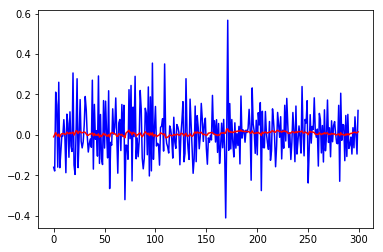

In [17]:
plot_ground_truth(predictions, target_test_vals)

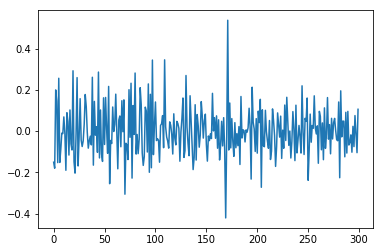

In [18]:
plot_difference(predictions, target_test_vals)

In [19]:
# logistic regression model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, target_test_vals = logistic_regression_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  194.599095       235.235688            0.208822   
2020-12-01                20  235.235688       209.269302           -0.110385   
2020-12-02               205  209.269302       200.046567           -0.044071   
2020-12-03              1089  200.046567       196.392221           -0.018267   
2020-12-04               869  196.392221       192.979787           -0.017376   
...                      ...         ...              ...                 ...   
2024-03-14               460  137.730236       142.665923            0.035836   
2024-03-15               623  142.665923       133.579684           -0.063689   
2024-03-16               451  133.579684       145.518509            0.089376   
2024-03-17               599  145.518509       145.331626           -0.001284   
2024-03-18               459

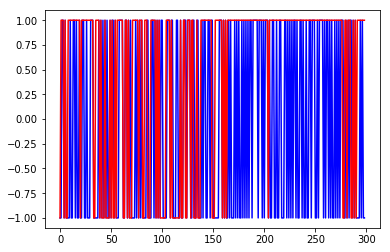

In [20]:
plot_ground_truth(predictions, target_test_vals)

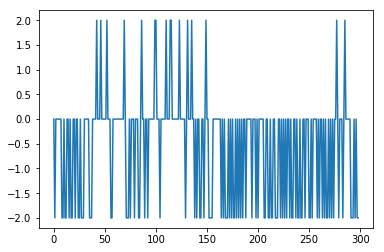

In [21]:
plot_difference(predictions, target_test_vals)

In [22]:
# K_Nearest_Neighbors model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, target_test_vals = knn_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  194.599095       235.235688            0.208822   
2020-12-01                20  235.235688       209.269302           -0.110385   
2020-12-02               205  209.269302       200.046567           -0.044071   
2020-12-03              1089  200.046567       196.392221           -0.018267   
2020-12-04               869  196.392221       192.979787           -0.017376   
...                      ...         ...              ...                 ...   
2024-03-13               388  152.105725       137.730236           -0.094510   
2024-03-14               460  137.730236       142.665923            0.035836   
2024-03-15               623  142.665923       133.579684           -0.063689   
2024-03-16               451  133.579684       145.518509            0.089376   
2024-03-17               599

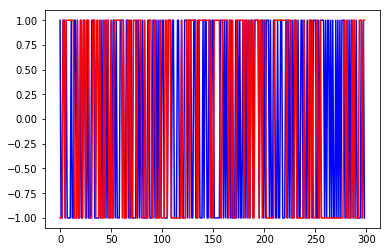

In [23]:
plot_ground_truth(predictions, target_test_vals)

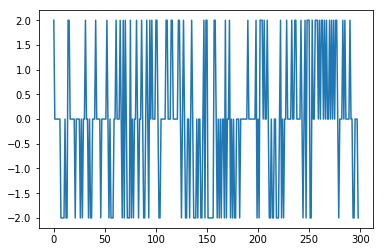

In [24]:
plot_difference(predictions, target_test_vals)

In [25]:
# MultinomialNB model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the naive bayes classifier to make prediction
predictions, target_test_vals = multinomialNB_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  194.599095       235.235688            0.208822   
2020-12-01                20  235.235688       209.269302           -0.110385   
2020-12-02               205  209.269302       200.046567           -0.044071   
2020-12-03              1089  200.046567       196.392221           -0.018267   
2020-12-04               869  196.392221       192.979787           -0.017376   
...                      ...         ...              ...                 ...   
2024-03-12               604  153.722403       152.105725           -0.010517   
2024-03-13               388  152.105725       137.730236           -0.094510   
2024-03-14               460  137.730236       142.665923            0.035836   
2024-03-15               623  142.665923       133.579684           -0.063689   
2024-03-16               451

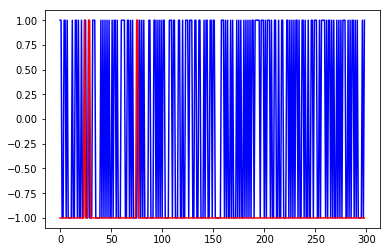

In [26]:
plot_ground_truth(predictions, target_test_vals)

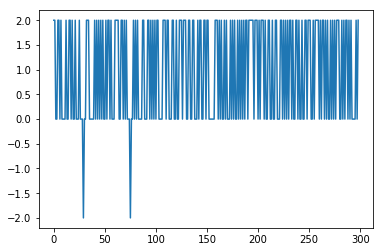

In [27]:
plot_difference(predictions, target_test_vals)

In [28]:
# Decision Tree model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the decision tree classifier to make prediction
predictions, target_test_vals = decision_tree_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  194.599095       235.235688            0.208822   
2020-12-01                20  235.235688       209.269302           -0.110385   
2020-12-02               205  209.269302       200.046567           -0.044071   
2020-12-03              1089  200.046567       196.392221           -0.018267   
2020-12-04               869  196.392221       192.979787           -0.017376   
...                      ...         ...              ...                 ...   
2024-03-11               692  161.745868       153.722403           -0.049605   
2024-03-12               604  153.722403       152.105725           -0.010517   
2024-03-13               388  152.105725       137.730236           -0.094510   
2024-03-14               460  137.730236       142.665923            0.035836   
2024-03-15               623

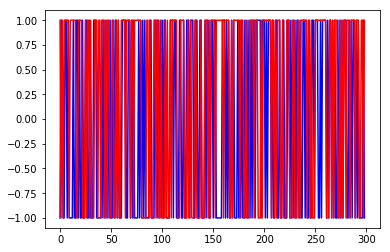

In [29]:
plot_ground_truth(predictions, target_test_vals)

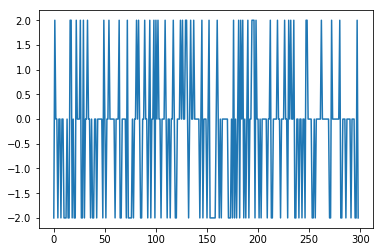

In [30]:
plot_difference(predictions, target_test_vals)

In [31]:
# Random Forest model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the random forest classifier to make prediction
predictions, target_test_vals = random_forest_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  194.599095       235.235688            0.208822   
2020-12-01                20  235.235688       209.269302           -0.110385   
2020-12-02               205  209.269302       200.046567           -0.044071   
2020-12-03              1089  200.046567       196.392221           -0.018267   
2020-12-04               869  196.392221       192.979787           -0.017376   
...                      ...         ...              ...                 ...   
2024-03-10               306  173.338523       161.745868           -0.066879   
2024-03-11               692  161.745868       153.722403           -0.049605   
2024-03-12               604  153.722403       152.105725           -0.010517   
2024-03-13               388  152.105725       137.730236           -0.094510   
2024-03-14               460

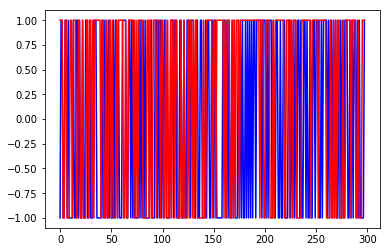

In [32]:
plot_ground_truth(predictions, target_test_vals)

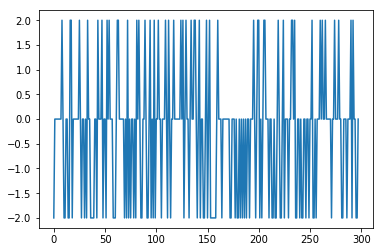

In [33]:
plot_difference(predictions, target_test_vals)

For predict the directionOfDailyChange:

logistic regression: 61.87% (Best)

k nearest neighbors: 52.17%
(I try the standardization and gridsearch, but the result has lower possibility then only use k_neighbors=3)

naive Bayes: 51.51%

decision tree: 54.52%

random forest: 54.03%